# Kaggle Midterm Notebook / Report

by John Sigmon (js85773)

## Overview

<p>
    The notebook is split into five sections, following the chronological order in which I approached the problem. The sections are:
  <ol>
    <li>Preliminary Graphing and Looking at the Data</li>
    <li>Bootstrapping the Dataset</li>
    <li>Feature Engineering</li>
    <li>Using My Feature Engineering Pipeline</li>
    <li>Boosted Trees</li>
    <li>Conclusion</li>
  </ol>
</p>
<p>
    Comments and thoughts accompany the code where necessary. While much of the project was exploration and just trying different things, I did attempt to validate my decisions. Each of the five sections can be run individually. Some cells do not run quickly. I marked those cells with a note. Additionally there were several Pandas warnings that could not be easily resolved or suppressed. They stemmed from accessing specific data points in a data frame, but would appear randomly, even when accessing data according to the documentation.
</p>

# Part 1 Preliminary Inspection
## Feature Engineering
### Load the data and split it
Initial loading of data<br>

In [32]:
import numpy as np
import math as m
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from IPython import get_ipython

import graphviz
import lime
import xgboost as xgb
InteractiveShell.ast_node_interactivity = "all"

In [33]:
def getTestFeatures():
    test_data = pd.read_csv("test.csv")
    test_data.F6 = np.log(test_data.F6)
    test_features = test_data.drop(['id'], axis=1)
    return np.array(test_features)

def makeSubmission(preds):
    new_index = np.arange(16384,32769,1)
    id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
    y_hat = pd.DataFrame(preds, columns=['Y'])
    frames = [id_col, y_hat]
    pred = pd.concat(frames, axis=1)
    return pred

In [34]:
filename = 'train.csv'
filepath = ''

data = pd.read_csv(filepath + filename)
#labels = data['Y']
#features = data.drop(['id', 'Y'], axis=1)

### Take a quick look

In [35]:
data.describe()
data.head()
#features.isnull().sum()
#print(features['F25'])
#features.dtypes

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
count,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,1.638300e+04,16383.000000,16383.000000,...,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,0.0,0.0,0.0
mean,8192.000000,0.941464,44312.117256,26032.070927,0.048953,40.002991,121039.419459,6.272233e+03,201731.398767,1.043216,...,1.047183,118208.827077,1.043460,1.043277,127587.576634,1.042361,52450.117256,NaN,NaN,NaN
std,4729.509065,0.234762,34815.325971,35742.773305,0.281347,4.998992,5802.987367,1.124685e+05,100732.735724,0.249209,...,0.285203,11021.402921,0.250144,0.268421,19031.948437,0.247142,34815.325971,NaN,NaN,NaN
min,1.000000,0.000000,999.000000,43.000000,0.000000,21.000000,118751.000000,1.000000e+03,15429.000000,1.000000,...,1.000000,5163.000000,1.000000,1.000000,13223.000000,1.000000,9137.000000,NaN,NaN,NaN
25%,4096.500000,1.000000,21896.000000,4603.000000,0.000000,37.000000,119325.000000,1.000000e+03,130752.000000,1.000000,...,1.000000,118832.000000,1.000000,1.000000,126972.000000,1.000000,30034.000000,NaN,NaN,NaN
50%,8192.000000,1.000000,36806.000000,13819.000000,0.000000,40.000000,119868.000000,1.000000e+03,143236.000000,1.000000,...,1.000000,119453.000000,1.000000,1.000000,127528.000000,1.000000,44944.000000,NaN,NaN,NaN
75%,12287.500000,1.000000,75414.000000,41799.500000,0.000000,43.000000,120739.000000,2.000000e+03,303218.000000,1.000000,...,1.000000,119703.000000,1.000000,1.000000,129100.000000,1.000000,83552.000000,NaN,NaN,NaN
max,16383.000000,1.000000,314150.000000,311733.000000,7.000000,59.000000,269481.000000,1.108900e+07,333172.000000,9.000000,...,13.000000,312049.000000,12.000000,8.000000,295412.000000,8.000000,322288.000000,NaN,NaN,NaN


,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1,1,38733,61385,0,38,118751,1000,32020,1,...,1,118830,1,1,126461,1,46871,NaN,NaN,NaN
1,2,1,34248,51329,0,41,120800,1000,130630,1,...,1,118832,1,1,130296,1,42386,NaN,NaN,NaN
2,3,1,15830,5522,0,50,118779,1000,303218,2,...,1,118832,1,2,127063,1,23968,NaN,NaN,NaN
3,4,1,19417,6754,0,45,123163,2000,19024,1,...,1,118832,1,1,15274,1,27555,NaN,NaN,NaN
4,5,1,42122,16991,0,41,119193,1000,303218,1,...,1,118832,1,1,133491,1,50260,NaN,NaN,NaN


Immediately we see that the last three columns are all floats, but listed as NaN. These can all be safely deleted.

In [36]:
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)

### Look for Outliers

Lets make a quick scatter plot of each feature column. (Output supressed for brevity)

In [37]:
#sns.set_style("whitegrid")
#for column in features.columns:
#    _ = sns.regplot(features[column], features[column], scatter_kws={"color":"darkred","alpha":0.3,"s":10}, fit_reg=False)
#    plt.show()

We notice severe outliers in:<br>`F6`<br>`F16`<br>`F20`<br><br>
We notice moderate outliers in:<br>`F3`<br>`F5`<br>`F8`<br>`F18`<br>`F24`<br><br>
We notice odd groupings in <br>`F7`<br>`F10`<br>`F12`<br>`F19`<br>`F22`<br><br>
Going in order, `F6`

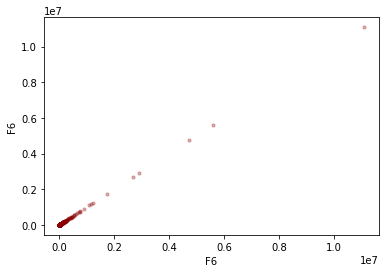

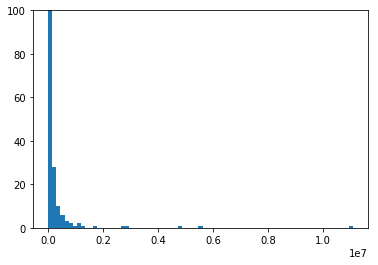

In [38]:
_ = sns.regplot(data.F6, data.F6, scatter_kws={"color":"darkred","alpha":0.3,"s":10}, fit_reg=False)
plt.show()
_ = plt.hist(data['F6'], bins=75)
_ = plt.ylim([0, 100])
plt.show()

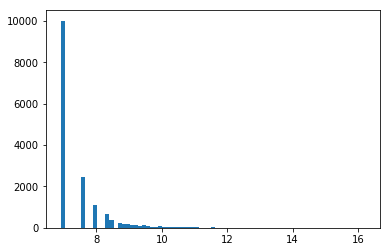

In [39]:
_ = plt.hist(np.log(data.F6), bins=75)

We can afford to lose 10 data points out of 14,000. Drop the ten huge outliers...

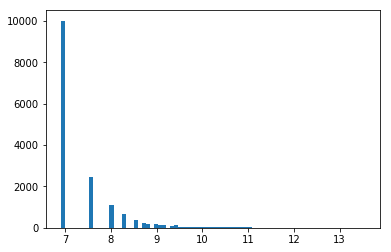

In [40]:
for i in range(10):
    data_point = data['F6'].idxmax()
    data.drop([data_point], inplace=True)
_ = plt.hist(np.log(data.F6), bins=75)

This feature looks more usable in this form. Lets keep it for now, but keep an eye on it.

In [41]:
data.F6 = np.log(data.F6)

In [42]:
#data_point = features['F6'].idxmax()
#while features.iloc[data_point]['F6'] > 0.6*10**7:
#    data_point = features['F6'].idxmax()
#    features.drop([data_point], inplace=True)
#    labels.drop([data_point], inplace=True)

#print(features.shape)
#print(labels.shape)

Now lets clean up `F16`

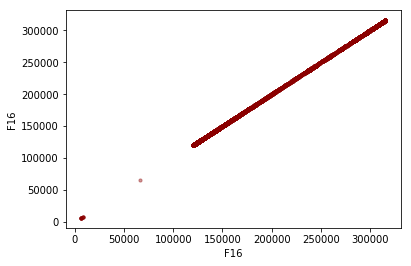

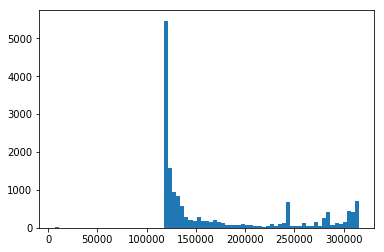

In [43]:
_ = sns.regplot(data.F16, data.F16, scatter_kws={"color":"darkred","alpha":0.4,"s":10}, fit_reg=False)
plt.show()
_ = plt.hist(data['F16'], bins=75)
plt.show()

Whatever this is, its clearly bounded by about 120,000 on the bottom and about 325,000 above. We can safely drop all values outside of that range.

In [44]:
print("Mode of F16 is: {}".format(data.F16.mode()))
bound = 119774
print("Counts of occurences of {} is: {}".format(bound,
                                                 data.F16[data.F16 == 119774].count()))

Mode of F16 is: 0    119777
dtype: int64
Counts of occurences of 119774 is: 0


In [45]:
data = data[data.F16 >= 119000]

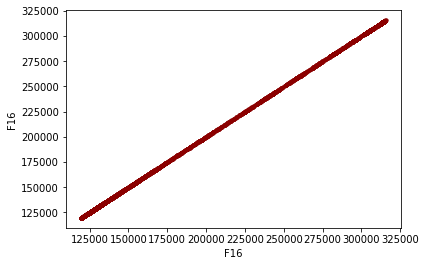

(16360, 26)

In [46]:
_ = sns.regplot(data.F16, data.F16, scatter_kws={"color":"darkred","alpha":0.4,"s":10}, fit_reg=False)
plt.show()
data.shape

Now we look at `F20`

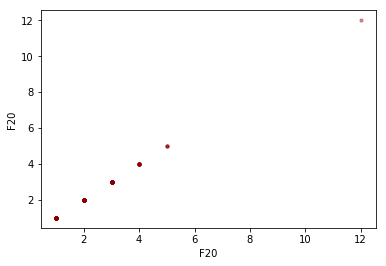

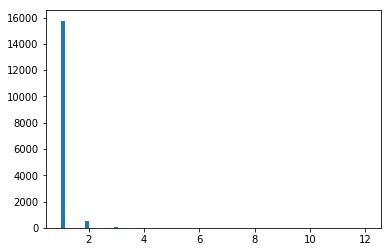

In [47]:
_ = sns.regplot(data.F20, data.F20, scatter_kws={"color":"darkred","alpha":0.4,"s":10}, fit_reg=False)
plt.show()
_ = plt.hist(data['F20'], bins=75)
plt.show()

Upon closer inspection, this data looks categorical, with almost all counts being in category 1. For simplicity, lets take those random $12$s and scoot them closer in.

In [48]:
for i in range(6,13):
    print("There are {} {}'s.".format(data.F20[data.F20 == i].count(), i))

There are 0 6's.
There are 0 7's.
There are 0 8's.
There are 0 9's.
There are 0 10's.
There are 0 11's.
There are 1 12's.


Since there is only one $12$, and almost all the other data points are $1$, let's just find that $12$ and drop it.

In [49]:
data = data[data.F20 != 12]

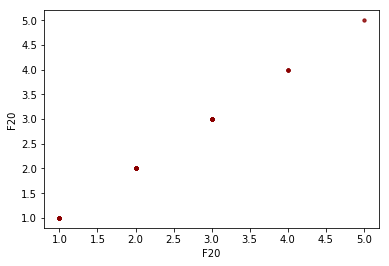

(16359, 26)

In [50]:
_ = sns.regplot(data.F20, data.F20, scatter_kws={"color":"darkred","alpha":0.4,"s":10}, fit_reg=False)
plt.show()
data.shape

At this point all the severe outliers are removed, and we can run a few preliminary models before moving on to some finer data inspection and feature engineering.

## Preliminary Modeling

In [51]:
labels = data['Y']
features = data.drop(['id', 'Y'], axis=1)

### Simple Logistic Regression

10 fold CV, and average the accuracies. We will try with L1 penalty and L2 penalty.

In [52]:
accuracies = [] 
weights_L1 = []
for i in range(10):
    rand = np.random.randint(1, 100)
    X_train, X_test, y_train, y_test = train_test_split(features, labels)
    clf = LogisticRegression(penalty='l1', max_iter=1000, random_state=rand)
    _ = clf.fit(X_train, y_train)
    accuracies.append(clf.score(X_test, y_test))
    weights_L1.append(clf.coef_)

accuracies = np.array(accuracies)
print("Mean for L1 norm is: {}".format(np.mean(accuracies, axis=0)))
print("St Dev for L1 norm is: {}".format(np.std(accuracies, axis=0)))
print('')

accuracies = [] 
weights_L2 = []
for i in range(10):
    rand = np.random.randint(1, 100)
    X_train, X_test, y_train, y_test = train_test_split(features, labels)
    clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=rand)
    _ = clf.fit(X_train, y_train)
    accuracies.append(clf.score(X_test, y_test))
    weights_L2.append(clf.coef_)
    
accuracies = np.array(accuracies)
print("Mean for L2 norm is: {}".format(np.mean(accuracies, axis=0)))
print("St Dev for L2 norm is: {}".format(np.std(accuracies, axis=0)))

Mean for L1 norm is: 0.9406601466992666
St Dev for L1 norm is: 0.0028198034575810083

Mean for L2 norm is: 0.9419559902200488
St Dev for L2 norm is: 0.0027274493432536714


Lets just average all these weights and use them.

In [53]:
#avgs = np.array([weights_L1, weights_L2])
#avgs = np.mean(np.mean(avgs, axis = 0), axis=2).reshape(10,)
clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=rand)
_ = clf.fit(features, labels)

In [54]:
test_data = pd.read_csv("test.csv")

In [55]:
test_data.F6 = np.log(test_data.F6)
test_features = test_data.drop(['id'], axis=1)
_ = clf.predict(test_features)
new_index = np.arange(16384,32769,1)

In [56]:
id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
y_hat = pd.DataFrame(_, columns=['Y'])
frames = [id_col, y_hat]
pred = pd.concat(frames, axis=1)

In [57]:
filename = 'prediction_logistic.csv'
pred.to_csv(filename, encoding='utf-8', index=False)

Once I finally got the submission in correctly, this only gave a score of 0.50, not great.

### K-Nearest Neighbors

10 fold CV, and $n$ from 1 to 10 and average the accuracies.

In [58]:
labels = data['Y']
features = data.drop(['id', 'Y'], axis=1)

#### Note this cell takes a long time to run

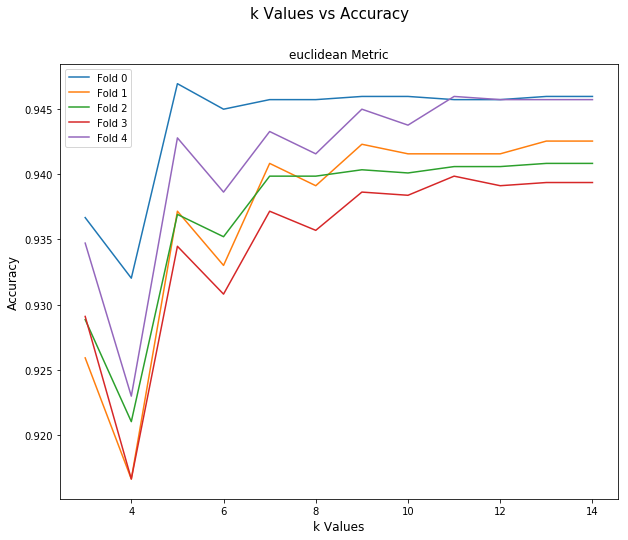

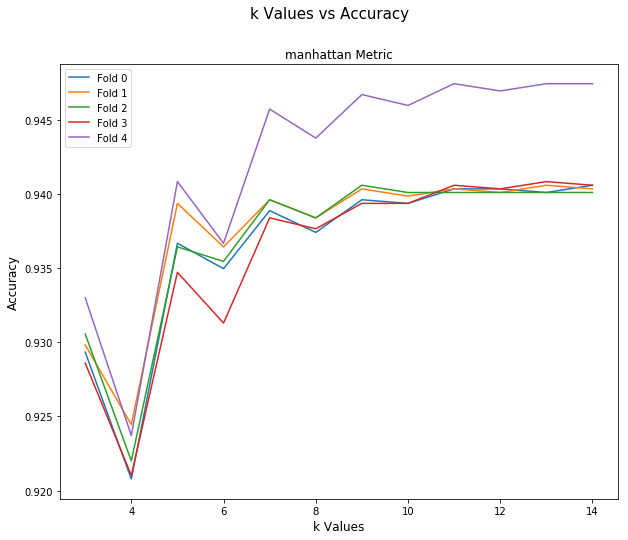

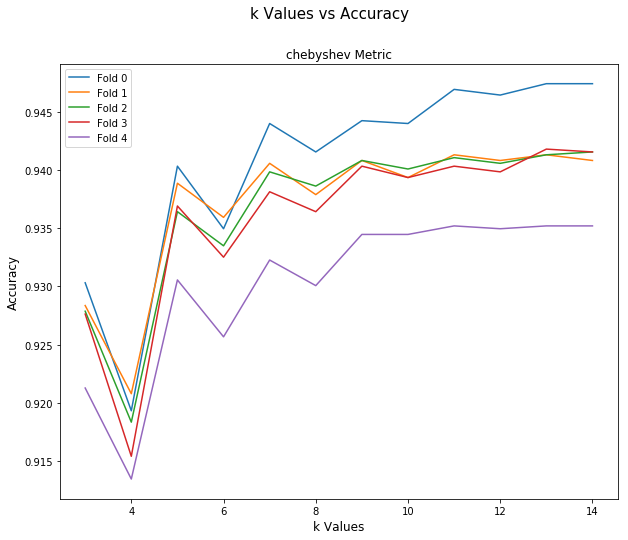

In [59]:
metrics = ['euclidean', 'manhattan', 'chebyshev']
folds = 5
k_vals = np.arange(3, 15, 1)
scores = np.empty((folds,len(k_vals)))

for metric in metrics:
    for i in range(folds):
        score = []
        X_train, X_test, y_train, y_test = train_test_split(features, labels)
        for k in k_vals:
            clf = KNeighborsClassifier(n_neighbors=k, metric=metric)
            _ = clf.fit(X_train, y_train)
            score.append(clf.score(X_test, y_test))
        scores[i, :] = score
    _ = plt.figure(figsize = (10,8))
    for i in range(folds):
        _ = plt.plot(k_vals, scores[i,:], label="Fold {}".format(i))

    _ = plt.xlabel("k Values", fontsize=12)
    _ = plt.ylabel("Accuracy", fontsize=12)
    _ = plt.suptitle("k Values vs Accuracy", fontsize=15)
    _ = plt.title("{} Metric".format(metric))
    _ = plt.legend()

### XGBoost

In [60]:
labels = data['Y']
features = data.drop(['id', 'Y'], axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)
y_train = y_train.reshape(12269,1)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [62]:
# specify parameters via map
param = {'max_depth':7, 'eta':0.7, 'gamma':0.8, 'silent':1, 'objective':'binary:logistic', 
         'early_stopping_rounds':5}
num_round = 200

bst = xgb.train(param, dtrain, num_round)
#pred = bst.predict(dtest)

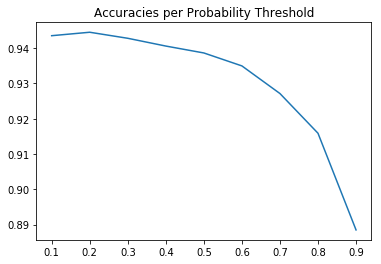

In [63]:
thresholds = np.arange(0.1, 1, 0.1)
scores = []
for alpha in thresholds:
    pred = bst.predict(dtest)
    for i in range(len(pred)):
        if pred[i] > alpha:
            pred[i] = 1 
        else:
            pred[i] = 0
    scores.append(accuracy_score(y_test, pred))

_ = plt.plot(thresholds, scores)
_ = plt.title('Accuracies per Probability Threshold')

In [64]:
scores

[0.943520782396088,
 0.9444987775061124,
 0.9427872860635697,
 0.9405867970660147,
 0.9386308068459658,
 0.9349633251833741,
 0.9271393643031784,
 0.9158924205378973,
 0.8885085574572127]

In [65]:
#test_data = pd.read_csv("test.csv")
#test_data.F6 = np.log(test_data.F6)
test_features = test_data.drop(['id'], axis=1)
dtest = xgb.DMatrix(test_features)
_ = bst.predict(dtest)
new_index = np.arange(16384,32769,1)
id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
y_hat = pd.DataFrame(_, columns=['Y'])
frames = [id_col, y_hat]
pred = pd.concat(frames, axis=1)
filename = 'prediction_xgb.csv'
pred.to_csv(filename, encoding='utf-8', index=False)

In [66]:
# Plotting the tree
#_ = xgb.plot_tree(bst)
#fig = plt.gcf()
#fig.set_size_inches(150, 100)
#plt.show()

It looks like the base models are maxing out accuracy around $0.94$. ~~Time to do some more feature engineering and see if we can improve.~~<br>
For curiosity, I want to submit just a column of ones.

In [67]:
ones = np.ones((32769-16384, 1))
new_index = np.arange(16384,32769,1)
id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
y_hat = pd.DataFrame(ones, columns=['Y'])
frames = [id_col, y_hat]
pred = pd.concat(frames, axis=1)
filename = 'prediction_lazyones.csv'
pred.to_csv(filename, encoding='utf-8', index=False)

For the record this did just as good as my logistic regression and KNN models.

# Part 2 Bootstrapping
I wanted to try to bootstrap an enormous data set and see if it was able to fit the data better, since I wasn't having much luck so far.

In [68]:
get_ipython().magic('reset -sf') #reset workspace variables
import numpy as np
import math as m
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell

from pandas.plotting import scatter_matrix

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import graphviz
import lime
import xgboost as xgb
InteractiveShell.ast_node_interactivity = "all"

In [69]:
#############################################################
# Pipeline for train.csv
#############################################################
def pipeline(data):
    # Drop empty columns
    garbage = ['F25', 'F26', 'F27']
    data.drop(garbage, axis=1, inplace=True)
    
    # Drop columns with very low correlation to label
    low_corr = ['F20', 'F23', 'F21', 'F18', 'F1', 'F24', 
            'F11', 'F13', 'F2', 'F15', 'F8', 'F14', 'F22']
    data.drop(low_corr, axis=1, inplace=True)
    data.drop(['id'], axis=1, inplace=True)
    
    # Drop duplicate columns
    dups = ['F9', 'F12']
    data.drop(dups, axis=1, inplace=True)

    # F6
    for i in range(10):
        data_point = data['F6'].idxmax()
        data.drop([data_point], inplace=True)
    data.F6 = np.log(data.F6)

    # F16
    data = data[data['F16'] > 115000]
    data.F16 -= data.F16.min()
    data.F16 /= m.sqrt(data.F16.std())

    # F20
    #data = data[data.F20 != 12]
    
    # F3
    data.F3 += 1
    data.F3 = np.log(data.F3)
    
    # F4
    data = zeroMean(data, 'F4')
    
    # F5
    data = data[data.F5 < 180000]
    data.F5 -= data.F5.min()
    data.F5 /= m.sqrt(data.F5.std())
    
    # F7
    column = 'F7'
    data.loc[data[column] < 75000, column] = 1
    data.loc[(data[column] < 215000) & (data[column] > 2), column] = 2
    data.loc[data[column] > 215000, column] = 3
    
    # F10
    column = 'F10'
    data = data[data[column] < 200000]
    data = data[data[column] > 120000]
    data.F10 -= data.F10.min()
    data.F10 /= m.sqrt(data.F10.std())
    
    # F17
    column = 'F17'
    data.F17 -= data.F17.min()
    data.F17 /= m.sqrt(data[column].std())
    
    # F19
    data = data[data.F19 < 300000]
    data.F19 /= m.sqrt(data.F19.std())
    
    return data

#############################################################
# Pipeline for test.csv
#############################################################
def testPipeline(data):
     # Drop columns with very low correlation to label
    low_corr = ['F20', 'F23', 'F21', 'F18', 'F1', 'F24', 
            'F11', 'F13', 'F2', 'F15', 'F8', 'F14', 'F22']
    data.drop(low_corr, axis=1, inplace=True)
    data.drop(['id'], axis=1, inplace=True)
    
    # Drop duplicate columns
    dups = ['F9', 'F12']
    data.drop(dups, axis=1, inplace=True)

    # F6
    data.F6 = np.log(data.F6)

    # F16
    data.F16 -= data.F16.min()
    data.F16 /= m.sqrt(data.F16.std())

    # F20
    #data = data[data.F20 != 12]
    
    # F3
    data.F3 += 1
    data.F3 = np.log(data.F3)
    
    # F4
    data = zeroMean(data, 'F4')
    
    # F5
    data.F5 -= data.F5.min()
    data.F5 /= m.sqrt(data.F5.std())
    
    # F7
    column = 'F7'
    data.loc[data[column] < 75000, column] = 1
    data.loc[(data[column] < 215000) & (data[column] > 2), column] = 2
    data.loc[data[column] > 215000, column] = 3
    
    # F10
    data.F10 -= data.F10.min()
    data.F10 /= m.sqrt(data.F10.std())
    
    # F17
    column = 'F17'
    data.F17 -= data.F17.min()
    data.F17 /= m.sqrt(data[column].std())
    
    # F19
    data.F19 /= m.sqrt(data.F19.std())
    
    return data

#############################################################
# Writes a file for Kaggle Submission
#############################################################
def makeFile(pred, filename):
    new_index = np.arange(16384,32769,1)
    id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
    y_hat = pd.DataFrame(pred, columns=['Y'])
    frames = [id_col, y_hat]
    pred = pd.concat(frames, axis=1)
    pred.to_csv(filename, encoding='utf-8', index=False)

def zeroMean(data, column):
    data[column] -= data[column].mean()
    data[column] /= m.sqrt(data[column].std())
    return data

In [70]:
filename = 'train.csv'
filepath = ''
data = pd.read_csv(filepath + filename)

In [71]:
new_data = pipeline(data)

/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [72]:
X_boot = np.zeros((10**6, new_data.shape[1]))

#### Note this cell runs for a long time

In [73]:
for i in range(X_boot.shape[0]):
    #seed = np.random.randint(0,100)
    rand = np.random.randint(0, new_data.shape[0])
    X_boot[i][:] = new_data.iloc[rand,:]

In [74]:
labels = X_boot[:,0]
features = X_boot[:,1:]

### Logistic Regression

#### Note this cell runs for a long time

In [75]:
accuracies = [] 
weights_L1 = []
for i in range(10):
    rand = np.random.randint(1, 100)
    X_train, X_test, y_train, y_test = train_test_split(features, labels)
    clf = LogisticRegression(penalty='l1', max_iter=1000, random_state=rand)
    _ = clf.fit(X_train, y_train)
    accuracies.append(clf.score(X_test, y_test))
    weights_L1.append(clf.coef_)

accuracies = np.array(accuracies)
print("Mean for L1 norm is: {}".format(np.mean(accuracies, axis=0)))
print("St Dev for L1 norm is: {}".format(np.std(accuracies, axis=0)))
print('')

Mean for L1 norm is: 0.9421592000000001
St Dev for L1 norm is: 0.00039964704427780396



In [76]:
_ = clf.fit(features, labels)

In [79]:
test_data = pd.read_csv('test.csv')
test_data = testPipeline(test_data)
preds = clf.predict(test_data)
pred = makeFile(preds, 'prediction_bootstrap_log.csv')

Logistic Regression doesnt seem to work very well ever on this data set. I'm going to retire it.

### Gradient Boosting

In [80]:
new_data.columns

Index(['Y', 'F3', 'F4', 'F5', 'F6', 'F7', 'F10', 'F16', 'F17', 'F19'], dtype='object')

#### Note this cell runs for a long time

In [81]:
clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, 
                                 n_estimators=500, max_depth=6, subsample=0.5)
_ = clf.fit(features, labels)
test_data = pd.read_csv('test.csv')
test_data = testPipeline(test_data)
pred = clf.predict(test_data)
makeFile(pred, 'prediction-pipelined-bootstrapped-gradboost.csv')

None of the bootstrapping seemed to work very well. Looking back, this could have been because of my feature engineering. I did not have enough days (submissions) at the end to try it again combined with later methods to see if it worked better. At this point I decided I had to do some more feature engineering to get more out of this data set.

# Part 3 Feature Engineering
#### Coming back to Part 1
We notice severe outliers in:<br>`F6`<br>`F16`<br>`F20`<br><br>
We notice moderate outliers in:<br>`F3`<br>`F5`<br>`F8`<br>`F18`<br>`F24`<br><br>
We notice odd groupings in <br>`F7`<br>`F10`<br>`F12`<br>`F19`<br>`F22`<br><br>
Lets quickly fix F6, F16, and F20 again.

In [82]:
get_ipython().magic('reset -sf')
import numpy as np
import math as m
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell

from pandas.plotting import scatter_matrix

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import graphviz
import lime
import xgboost as xgb
InteractiveShell.ast_node_interactivity = "all"

In [83]:
def corrHeatMap(data):
    cols = data.columns
    xticks = np.arange(0,len(cols), 1)
    fig, ax = plt.subplots(figsize=(10,10))
    _ = plt.imshow(data.corr())
    _ = plt.colorbar()
    _ = ax.set_xticks(xticks)
    _ = ax.set_yticks(xticks)
    _ = ax.set_xticklabels(data.columns)
    _ = ax.set_yticklabels(data.columns)

def pltHist(data, column, num_bins=50):
    _ = plt.hist(data[column], num_bins, normed=1, facecolor='green', alpha = 0.5)
    _ = plt.xlabel(column)
    _ = plt.title('Histogram of {}'.format(column))
    
def zeroMean(data, column):
    data[column] -= data[column].mean()
    data[column] /= m.sqrt(data[column].std())
    return data

def dropKLargest(data, column, k):
    for i in range(k):
        data_point = data[column].idxmax()
        data.drop([data_point], inplace=True)

        # check this functionality
def dropLargestBound(data, column, bound):
    data_point = data[column].idxmax()
    print(data.iloc[data_point][column])
    while(data.iloc[data_point][column] > bound):
        data.drop([data_point], axis=0, inplace=True)
        data_point = data[column].idxmax()
        print(data_point)

# Assumes id column has already been stripped
def splitData(data):
    labels = data['Y']
    features = data.drop(['Y'], axis=1)
    return features, labels

In [84]:
filename = 'train.csv'
filepath = ''
data = pd.read_csv(filepath + filename)
data.drop(['id'], axis=1, inplace=True)

# Drop empty columns
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)

# F6
for i in range(10):
    data_point = data['F6'].idxmax()
    data.drop([data_point], inplace=True)
data.F6 = np.log(data.F6)

# F16
data = data[data.F16 >= 119000]

# F20
data = data[data.F20 != 12]

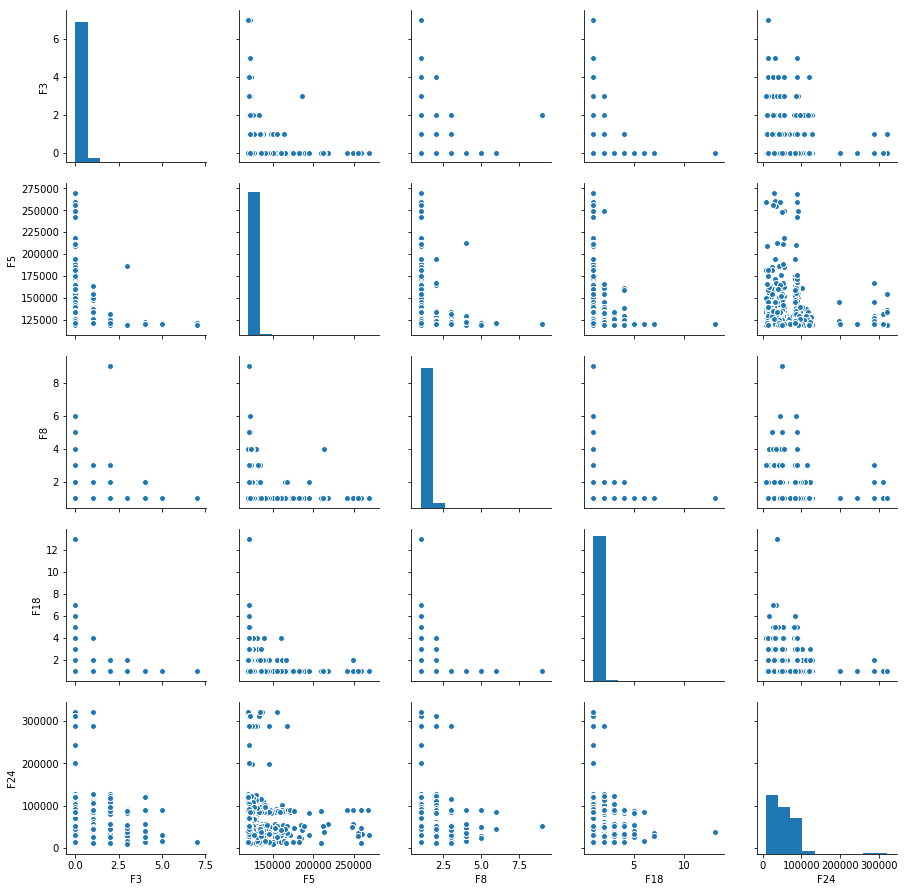

In [85]:
mod_outliers = ['F3', 'F5', 'F8', 'F18', 'F24']
_ = sns.pairplot(data[mod_outliers])

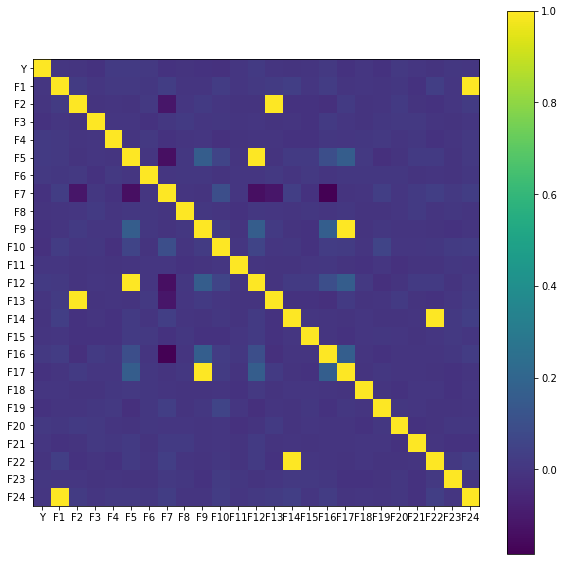

In [86]:
_ = corrHeatMap(data)

In [87]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.017506
F12    0.017506
F4     0.014835
F16    0.011408
F6     0.010885
F20    0.009697
F23    0.006785
F21    0.004126
F18    0.003530
F1     0.002134
F24    0.002134
F11    0.001027
F13   -0.000850
F2    -0.000850
F15   -0.004088
F8    -0.005040
F14   -0.005283
F22   -0.005283
F9    -0.009537
F17   -0.009537
F3    -0.009586
F7    -0.010218
F19   -0.011999
F10   -0.014681
Name: Y, dtype: float64


To be honest this looks like the columns are mostly garbage. I am going to save myself some trouble and drop columns with less than 1 percent correlation to the label.

In [88]:
low_corr = ['F20', 'F23', 'F21', 'F18', 'F1', 'F24', 
            'F11', 'F13', 'F2', 'F15', 'F8', 'F14', 'F22']
data.drop(low_corr, axis=1, inplace=True)

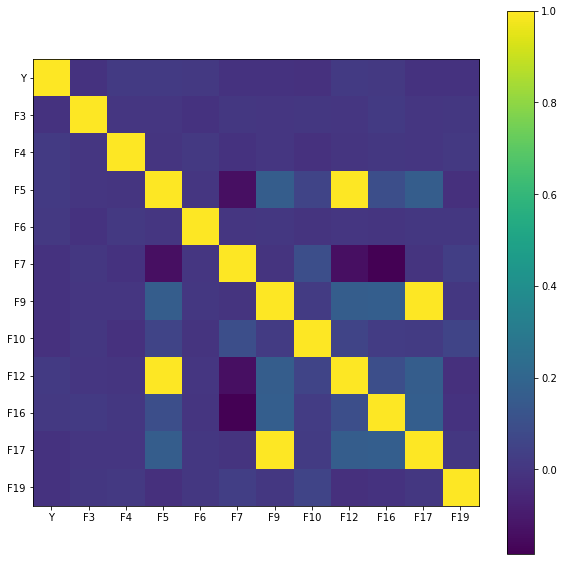

In [89]:
_ = corrHeatMap(data)

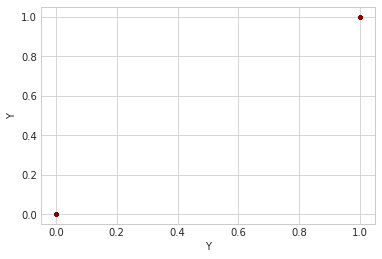

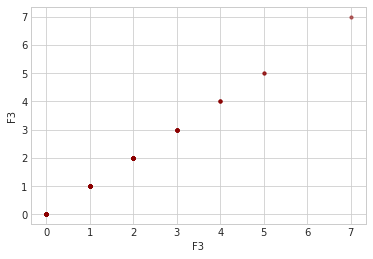

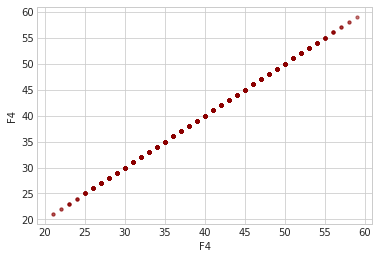

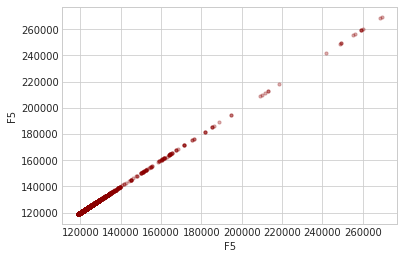

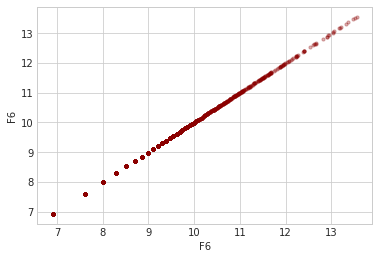

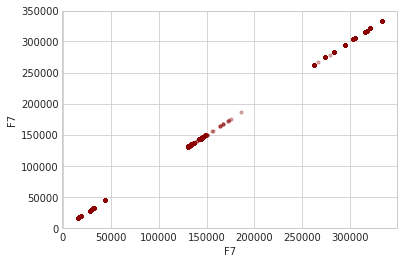

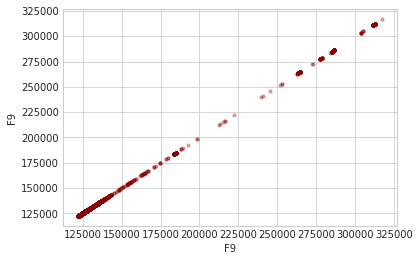

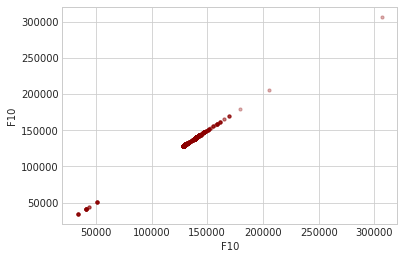

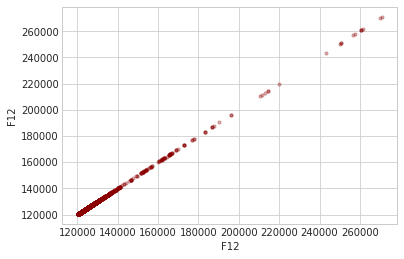

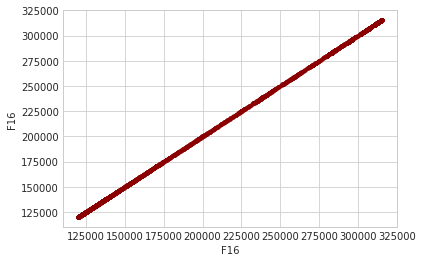

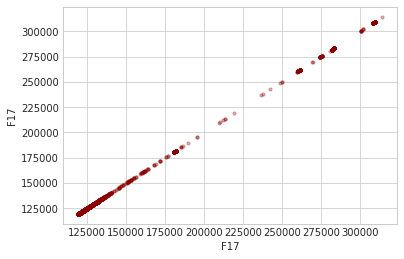

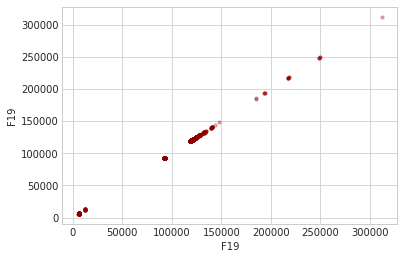

In [90]:
sns.set_style("whitegrid")
for column in data.columns:
    _ = sns.regplot(data[column], data[column], scatter_kws={"color":"darkred","alpha":0.3,"s":10}, fit_reg=False)
    plt.show()

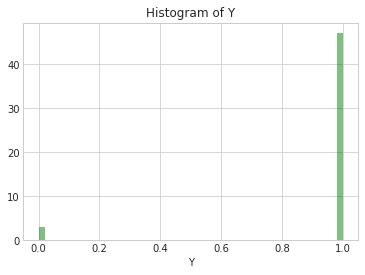

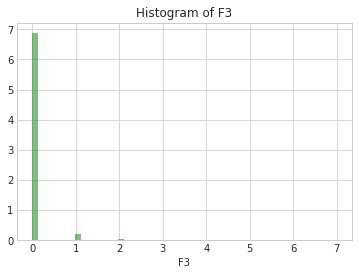

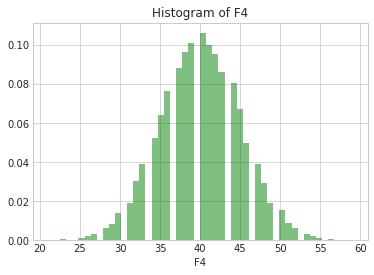

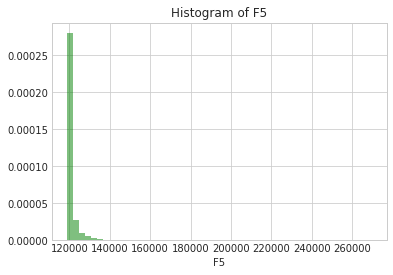

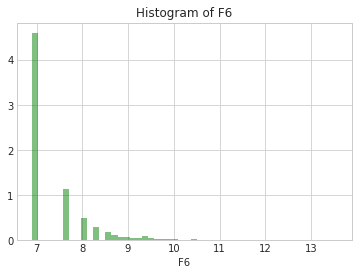

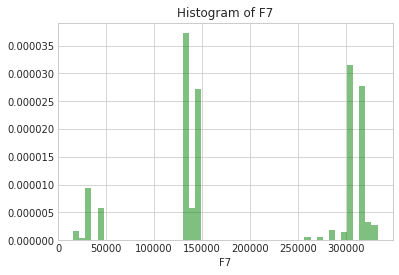

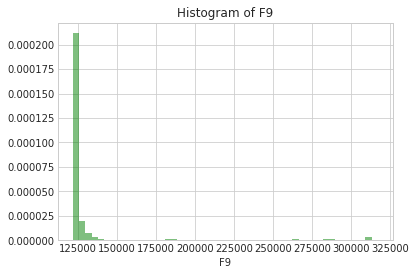

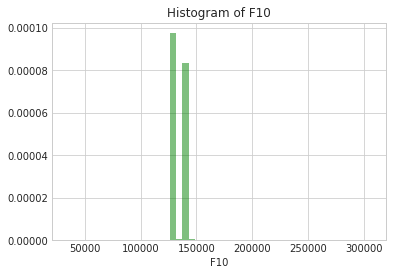

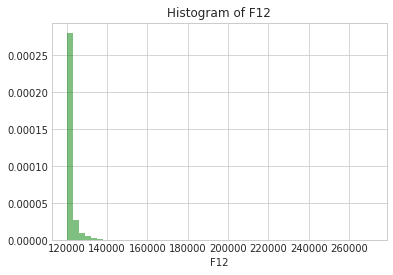

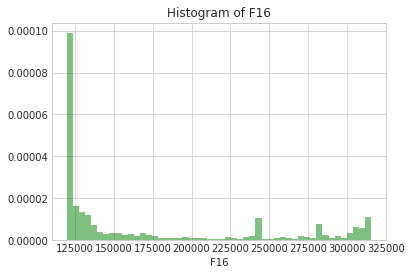

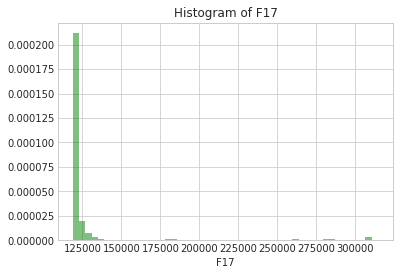

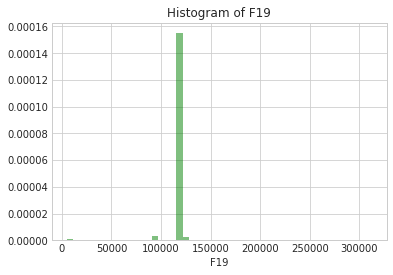

In [91]:
num_bins = 50
for column in data.columns:
    _ = plt.hist(data[column], num_bins, normed=1, facecolor='green', alpha = 0.5)
    _ = plt.xlabel(column)
    _ = plt.title('Histogram of {}'.format(column))
    plt.show()

## Start changing stuff
Let's take them in order.

#### F3

Lets convert it to log data.

In [92]:
data.F3 += 1
data.F3 = np.log(data.F3)

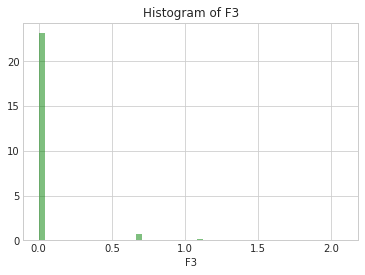

In [93]:
column = 'F3'
pltHist(data, column)

In [94]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F12    0.017506
F5     0.017506
F4     0.014835
F16    0.011408
F6     0.010885
F17   -0.009537
F9    -0.009537
F7    -0.010218
F3    -0.011799
F19   -0.011999
F10   -0.014681
Name: Y, dtype: float64


#### F4

This is obviously normal. Let's leave it in for now, it may make the model more robust to noise. I will convert it to standard normal.

In [95]:
column = 'F4'
data = zeroMean(data, column)

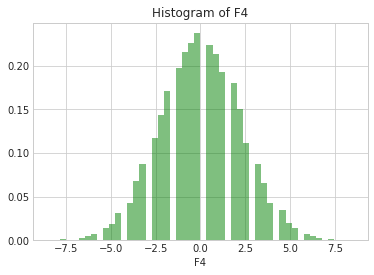

In [96]:
pltHist(data, column)

At least that is scaled. We can remove it later if necessary.

#### F5

Lets look at a log histogram.

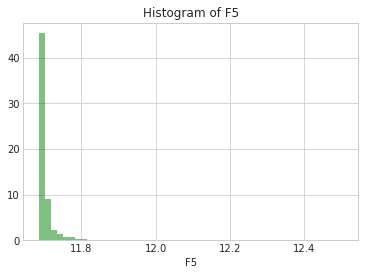

In [97]:
column = 'F5'
_ = plt.hist(np.log(data[column]), num_bins, normed=1, facecolor='green', alpha = 0.5)
_ = plt.xlabel(column)
_ = plt.title('Histogram of {}'.format(column))

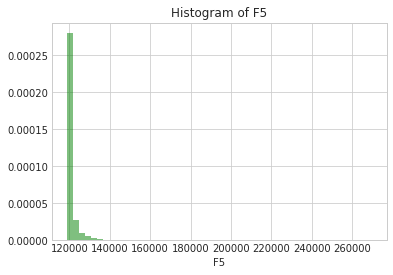

In [98]:
pltHist(data, column)

In [99]:
k = data[data[column] > 180000].count().F5

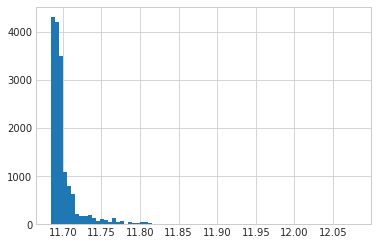

In [100]:
dropKLargest(data, column, k)
_ = plt.hist(np.log(data[column]), bins=75)

In [101]:
data.F5 = np.log(data.F5)

In [102]:
data = zeroMean(data, column)

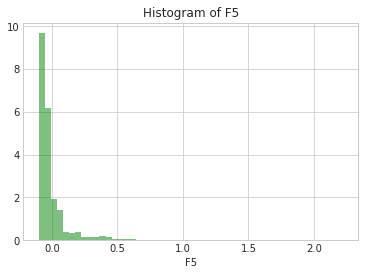

In [103]:
pltHist(data, column)

In [104]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020867
F12    0.020457
F4     0.015103
F16    0.011235
F6     0.010746
F7    -0.010140
F17   -0.010343
F9    -0.010343
F3    -0.011934
F19   -0.012046
F10   -0.014530
Name: Y, dtype: float64


We improved F5's correlation.

#### F6
This one has some interesting structure, lets zero mean it for now.

In [105]:
column = 'F6'
data = zeroMean(data, column)

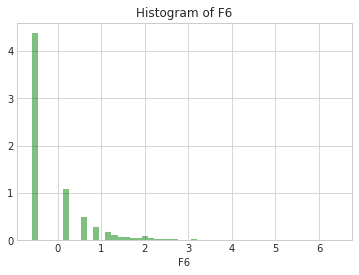

In [106]:
pltHist(data, column)

In [107]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020867
F12    0.020457
F4     0.015103
F16    0.011235
F6     0.010746
F7    -0.010140
F17   -0.010343
F9    -0.010343
F3    -0.011934
F19   -0.012046
F10   -0.014530
Name: Y, dtype: float64


#### F7
This column is definitely 3 categories. Lets lump them all together.

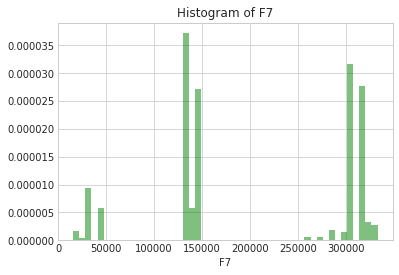

In [108]:
column = 'F7'
pltHist(data, column)

In [109]:
data.loc[data[column] < 75000, column] = 1
data.loc[(data[column] < 215000) & (data[column] > 2), column] = 2
data.loc[data[column] > 215000, column] = 3

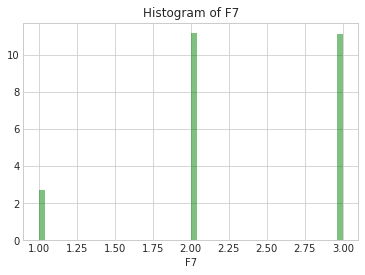

In [110]:
pltHist(data, column)

In [111]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020867
F12    0.020457
F4     0.015103
F16    0.011235
F6     0.010746
F7     0.003744
F17   -0.010343
F9    -0.010343
F3    -0.011934
F19   -0.012046
F10   -0.014530
Name: Y, dtype: float64


This didnt seem to help. We might as well leave F7 as is, or drop it.

#### F9
F9 is a duplicate of F17. Lets drop it and deal with it at the end.

In [112]:
data.drop('F9', axis=1, inplace=True)

#### F10

F10 is heavily concentrated, but has significant outliers on the 'left' side. Lets drop the ones on the right side.

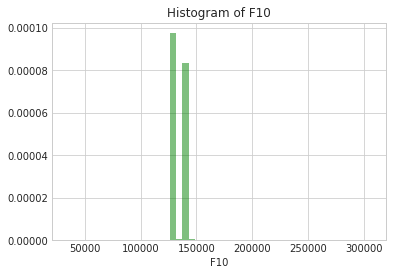

In [113]:
column = 'F10'
pltHist(data, column)
k = data[data[column] > 200000].count().F10

In [114]:
#dropKLargest(data, column, k)

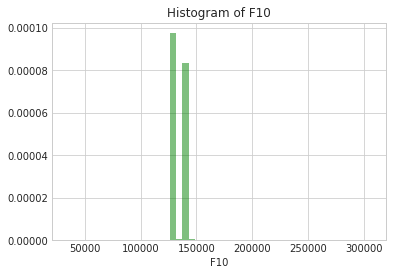

In [115]:
pltHist(data, column)

In [116]:
data[data[column] < 120000].Y

62       1
173      1
208      1
1714     1
1932     1
2022     1
3111     1
3197     1
3723     1
3846     1
4082     1
4204     1
4553     1
4727     1
4836     1
7294     1
8129     0
8164     1
8184     1
10033    1
10138    1
10523    1
10928    1
11481    0
13326    1
13493    1
14498    1
15412    1
15518    1
15738    1
Name: Y, dtype: int64

~~On nothing but my intuition, I am dropping all these far left outliers.~~<br>
I ended up dropping just the far left, and keeping the far right.

In [117]:
data = data[data[column] > 120000]

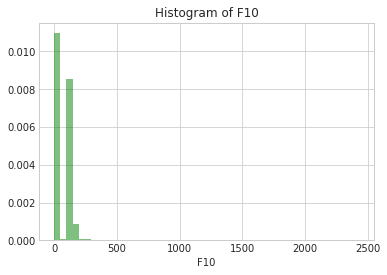

In [118]:
#data = zeroMean(data, column)
data.F10 -= data.F10.min()
data.F10 /= m.sqrt(data.F10.std())
pltHist(data, column)

In [119]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020871
F12    0.020461
F4     0.015123
F16    0.011061
F6     0.010908
F7     0.003719
F17   -0.010492
F19   -0.012023
F3    -0.012033
F10   -0.018158
Name: Y, dtype: float64


Our correlation went up. ~~Lets take the log also and see if that helps.~~ It did not help, so I removed those two cells.

#### F12
F12 is the same as F5, lets drop it.

In [120]:
data.drop('F12', axis=1, inplace=True)

#### F16

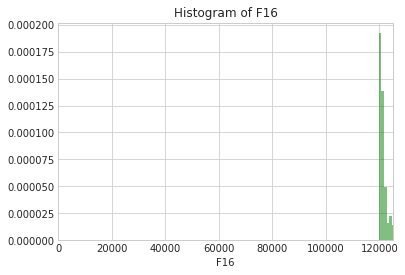

In [121]:
column = 'F16'
pltHist(data, column, num_bins=200)
_ = plt.xlim([0, 125000])

In [122]:
data[data[column] < 118000].count().F16

0

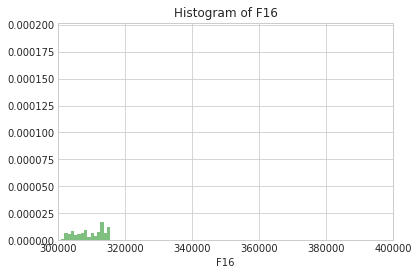

In [123]:
pltHist(data, column, num_bins=200)
_ = plt.xlim([300000, 400000])

In [124]:
data[data[column] > 320000].count().F16

0

In [125]:
data = zeroMean(data, column)

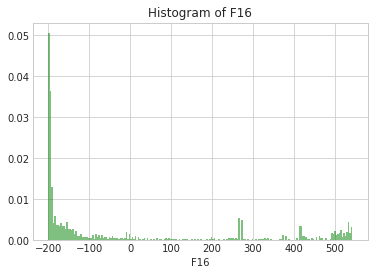

In [126]:
pltHist(data, column, num_bins=200)

In [127]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020871
F4     0.015123
F16    0.011061
F6     0.010908
F7     0.003719
F17   -0.010492
F19   -0.012023
F3    -0.012033
F10   -0.018158
Name: Y, dtype: float64


F16's correlation with the labels actually decreased slightly. Not sure what to do to this column. I'm going to leave it for now.

#### F17

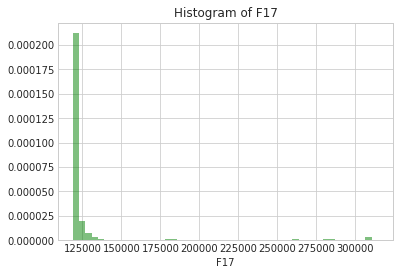

In [128]:
column = 'F17'
pltHist(data, column)

In [129]:
outliers = data[data[column] > 200000]
corr_matrix = outliers.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F4     0.040493
F17    0.021215
F10    0.003480
F5    -0.014851
F7    -0.017980
F19   -0.027720
F6    -0.056986
F3    -0.090701
F16   -0.103681
Name: Y, dtype: float64


Now that is interesting. The highest correlations I have seen so far are in the data points that are the outliers on this column. ~~Lets drop all those F17 outliers, log transform it, and zero mean it, and see what happens.~~

In [130]:
#data_copy = data[data[column] < 200000]
#data_copy = zeroMean(data_copy, column)
#data_copy['F17'] = np.log(data_copy['F17'])
#corr_matrix = data_copy.corr()
#print(corr_matrix['Y'].sort_values(ascending=False))

In [131]:
data.F17 -= data.F17.min()
data.F17 /= m.sqrt(data[column].std())
#data.F17 = np.exp(data.F17 + 1)

In [132]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020871
F4     0.015123
F16    0.011061
F6     0.010908
F7     0.003719
F17   -0.010492
F19   -0.012023
F3    -0.012033
F10   -0.018158
Name: Y, dtype: float64


#### F19
Lets drop the outlier and shift it.

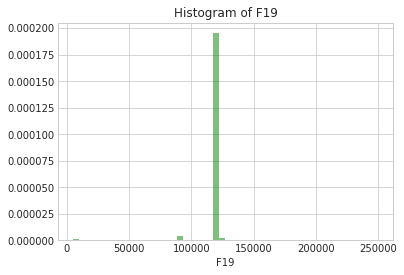

In [133]:
column = 'F19'
data = data[data.F19 < 300000]
pltHist(data, column)

In [134]:
data.F19 -= data.F19.mean()
data.F19 /= m.sqrt(data.F19.std())

In [135]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020817
F4     0.015114
F16    0.011068
F6     0.010905
F7     0.003727
F17   -0.010576
F3    -0.012030
F19   -0.012408
F10   -0.018148
Name: Y, dtype: float64


At this point I feel satisfied with my data engineering. The correlations started poor and did not improve much so I think its time to move on to some other things. First lets see if anything I did worked.

# Part 4 Trying to Use My Pipeline

In [136]:
get_ipython().magic('reset -sf')
import numpy as np
import math as m
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell

from pandas.plotting import scatter_matrix

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

import graphviz
import lime
import xgboost as xgb
InteractiveShell.ast_node_interactivity = "all"

In [137]:
#############################################################
# Pipeline for train.csv
#############################################################
def pipeline(data):
    # Drop empty columns
    garbage = ['F25', 'F26', 'F27']
    #if garbage in data.columns:
    data.drop(garbage, axis=1, inplace=True)
            
    # Drop columns with very low correlation to label
    #low_corr = ['F20', 'F23', 'F21', 'F18', 'F1', 'F24', 'F4',
    #        'F11', 'F13', 'F2', 'F15', 'F8', 'F14', 'F22']
    #data.drop(low_corr, axis=1, inplace=True)
    data.drop(['id'], axis=1, inplace=True)
    
    # Drop duplicate columns
    dups = ['F9', 'F12']
    data.drop(dups, axis=1, inplace=True)

    # F6
    #for i in range(10):
    #    data_point = data['F6'].idxmax()
    #    data.drop([data_point], inplace=True)
    data.F6 = np.log(data.F6)

    # F16
    data = data[data['F16'] > 115000]
    data.F16 -= data.F16.min()
    data.F16 /= m.sqrt(data.F16.std())

    # F20
    #data = data[data.F20 != 12]
    
    # F3
    data.F3 += 1
    data.F3 = np.log(data.F3)
    
    # F4
    #data.F4 -= data.F4.mean()
    #data.F4 /= m.sqrt(data.F4.std())
    
    # F5
    data = data[data.F5 < 180000]
    data.F5 -= data.F5.min()
    data.F5 /= m.sqrt(data.F5.std())
    
    # F7
    column = 'F7'
    #data.loc[data[column] < 75000, column] = 1
    #data.loc[(data[column] < 215000) & (data[column] > 2), column] = 2
    #data.loc[data[column] > 215000, column] = 3
    
    
    # F10
    column = 'F10'
    data = data[data[column] < 200000]
    data = data[data[column] > 120000]
    data.F10 -= data.F10.min()
    data.F10 /= m.sqrt(data.F10.std())
    
    # F17
    column = 'F17'
    data.F17 -= data.F17.min()
    data.F17 /= m.sqrt(data[column].std())
    
    # F19
    data = data[data.F19 < 300000]
    data.F19 /= m.sqrt(data.F19.std())
    
    return data

#############################################################
# Pipeline for test.csv
#############################################################
def testPipeline(data):
     # Drop columns with very low correlation to label
    #low_corr = ['F20', 'F23', 'F21', 'F18', 'F1', 'F24', 'F4',
    #        'F11', 'F13', 'F2', 'F15', 'F8', 'F14', 'F22']
    #data.drop(low_corr, axis=1, inplace=True)
    data.drop(['id'], axis=1, inplace=True)
    
       # Drop duplicate columns
    dups = ['F9', 'F12']
    data.drop(dups, axis=1, inplace=True)

    # F6
    #for i in range(10):
    #    data_point = data['F6'].idxmax()
    #    data.drop([data_point], inplace=True)
    data.F6 = np.log(data.F6 + 1)

    # F16
    #data = data[data['F16'] > 115000]
    data.F16 -= data.F16.min()
    data.F16 /= m.sqrt(data.F16.std())

    # F20
    #data = data[data.F20 != 12]
    
    # F3
    data.F3 += 1
    data.F3 = np.log(data.F3)
    
    # F4
    #data.F4 -= data.F4.mean()
    #data.F4 /= m.sqrt(data.F4.std())
    
    # F5
    #data = data[data.F5 < 180000]
    data.F5 -= data.F5.min()
    data.F5 /= m.sqrt(data.F5.std())
    
    # F7
    column = 'F7'
    #data.loc[data[column] < 75000, column] = 1
    #data.loc[(data[column] < 215000) & (data[column] > 2), column] = 2
    #data.loc[data[column] > 215000, column] = 3
    
    
    # F10
    column = 'F10'
    #data = data[data[column] < 200000]
    #data = data[data[column] > 120000]
    data.F10 -= data.F10.min()
    data.F10 /= m.sqrt(data.F10.std())
    
    # F17
    column = 'F17'
    data.F17 -= data.F17.min()
    data.F17 /= m.sqrt(data[column].std())
    
    # F19
    #data = data[data.F19 < 300000]
    data.F19 /= m.sqrt(data.F19.std())
    
    return data

#############################################################
# Writes a file for Kaggle Submission
#############################################################
def makeFile(pred, filename):
    new_index = np.arange(16384,32769,1)
    id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
    y_hat = pd.DataFrame(pred, columns=['Y'])
    frames = [id_col, y_hat]
    pred = pd.concat(frames, axis=1)
    pred.to_csv(filename, encoding='utf-8', index=False)

In [138]:
#############################################################
# Pipeline 2 for train.csv
#############################################################
def pipeline2(data):
    data = pipeline(data)
    features, labels = splitData(data)
    poly = PolynomialFeatures(2)
    return poly.fit_transform(features), labels

#############################################################
# Test Pipeline 2 for train.csv
#############################################################
def testPipeline2(data):
    data = testPipeline(data)
    poly = PolynomialFeatures(2)
    return poly.fit_transform(data)

In [139]:
def zeroMean(data, column):
    data[column] -= data[column].mean()
    data[column] /= m.sqrt(data[column].std())
    return data

def dropKLargest(data, column, k):
    for i in range(k):
        data_point = data[column].idxmax()
        data.drop([data_point], inplace=True)

# TODO        # check this functionality
def dropLargestBound(data, column, bound):
    data_point = data[column].idxmax()
    print(data.iloc[data_point][column])
    while(data.iloc[data_point][column] > bound):
        data.drop([data_point], axis=0, inplace=True)
        data_point = data[column].idxmax()
        print(data_point)

# Assumes id column has already been stripped
def splitData(data):
    labels = data['Y']
    features = data.drop(['Y'], axis=1)
    return features, labels

def pltHist(data, column, num_bins=50):
    _ = plt.hist(data[column], num_bins, normed=1, facecolor='green', alpha = 0.5)
    _ = plt.xlabel(column)
    _ = plt.title('Histogram of {}'.format(column))

In [144]:
filename = 'train.csv'
filepath = ''
data = pd.read_csv(filepath + filename)

## Gradient Boosting

In [147]:
features, labels = splitData(pipeline(data))

/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### Note this cell runs for a long time

In [149]:
# Some 5 Fold CV
depths = np.arange(3,15,1)
scores = np.empty((len(depths), 2))
count = 0
for depth in depths:
    accuracy = [] 
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(features, labels)
        clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, 
                                 n_estimators=500, max_depth=depth)
        _ = clf.fit(X_train, y_train)
        accuracy.append(clf.score(X_test, y_test))
        #print(accuracy)
    accuracies = np.array(accuracy)
    scores[count, 0] = np.mean(accuracies, axis=0)
    scores[count, 1] = np.std(accuracies, axis=0)
    count += 1

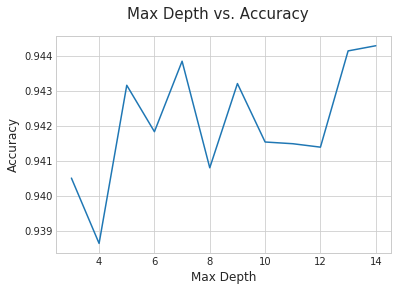

In [150]:
_ = plt.plot(depths, scores[:,0], label="Fold {}".format(i))
_ = plt.xlabel("Max Depth", fontsize=12)
_ = plt.ylabel("Accuracy", fontsize=12)
_ = plt.suptitle("Max Depth vs. Accuracy", fontsize=15)

In [151]:
clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, 
                                 n_estimators=500, max_depth=14, subsample=0.5)
_ = clf.fit(features, labels)
test_data = pd.read_csv('test.csv')
test_data = testPipeline(test_data)
pred = clf.predict(test_data)
makeFile(pred, 'prediction-pipelined-gradboost.csv')

Still not very impressive scores.

#### Lets try some polynomial data

In [155]:
filename = 'train.csv'
filepath = ''
data = pd.read_csv(filepath + filename)

In [156]:
poly_data, labels = pipeline2(data)

/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [157]:
clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, 
                                 n_estimators=500, max_depth=6, subsample=0.5)
_ = clf.fit(poly_data, labels)

In [158]:
test_data = pd.read_csv('test.csv')
test_data = testPipeline2(test_data)
pred = clf.predict(test_data)
makeFile(pred, 'prediction-pipelined-polynomial-gradboost.csv')

That one didnt do very well either.

## A different direction
Lets polynomial fit all the features and drop the ones that have less than one percent correlation with the labels.

In [159]:
data = pd.read_csv('train.csv')

In [160]:
data = pipeline(data)
features, labels = splitData(data)
poly = PolynomialFeatures(2)
poly_data = poly.fit_transform(features)
poly_data = pd.DataFrame(poly_data[1:,1:])
frames = [labels, poly_data]
full_poly_data = pd.concat(frames, axis=1)

/mnt/c/programming/Kaggle-Midterm/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


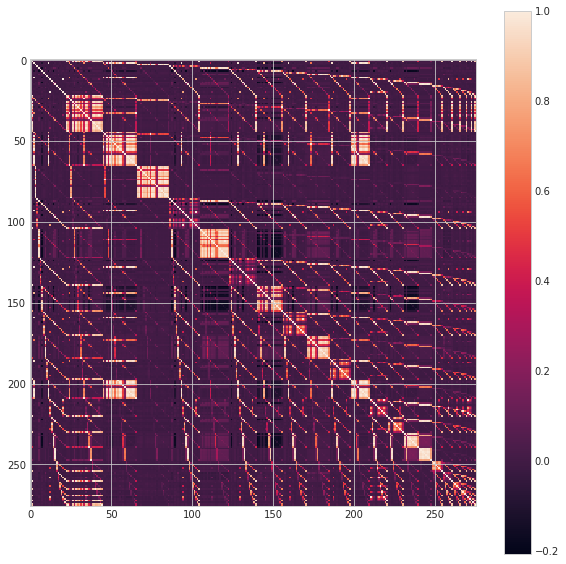

In [161]:
fig, ax = plt.subplots(figsize=(10,10))
_ = plt.imshow(full_poly_data.corr())
_ = plt.colorbar()

In [162]:
corr_matrix = full_poly_data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
88     0.017580
139    0.015357
150    0.015222
85     0.014909
6      0.014373
148    0.014148
149    0.013323
3      0.013296
152    0.012618
144    0.012460
151    0.012176
91     0.012104
99     0.011861
201    0.011777
57     0.011769
142    0.011768
101    0.011632
93     0.011366
153    0.010828
123    0.010788
189    0.010319
140    0.010069
222    0.009850
240    0.009566
212    0.009444
244    0.009406
96     0.009386
246    0.009352
71     0.009193
         ...   
160   -0.009199
273   -0.009237
34    -0.009337
229   -0.009565
228   -0.009577
170   -0.009642
178   -0.009793
180   -0.009890
125   -0.009904
179   -0.010485
76    -0.010755
27    -0.011006
138   -0.011302
129   -0.011794
174   -0.012271
182   -0.012350
5     -0.012373
133   -0.012384
122   -0.012634
137   -0.012823
108   -0.013574
121   -0.014719
26    -0.015968
64    -0.016275
208   -0.016288
23    -0.017268
32    -0.017276
274   -0.017730
43    -0.017960
22    -0.018199
Name: Y, Length: 276, dt

These correlations were so bad I didn't actually try it here. I wanted to come back to it at the end using the non engineered data set with boosted trees. It may have done better there.

# Part 5 Boosted Trees

In [163]:
get_ipython().magic('reset -sf')
import numpy as np
import math as m
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [164]:
def makeSubmission(preds):
    new_index = np.arange(16384,32769,1)
    id_col = pd.DataFrame(new_index, columns=['id'], dtype='int32')
    y_hat = pd.DataFrame(preds, columns=['Y'])
    frames = [id_col, y_hat]
    pred = pd.concat(frames, axis=1)
    return pred

In [165]:
data = pd.read_csv('train.csv')
data.drop(['id'], axis=1, inplace=True)
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)
dups = ['F12', 'F13', 'F17', 'F22', 'F24']
data.drop(dups, axis=1, inplace=True)

In [166]:
dtrain = xgb.DMatrix(data.drop('Y', axis=1), label=data.Y)

In [167]:
depths = [6, 7, 8, 9, 10]
bsts = []

for i in range(len(depths)):
    param = {'max_depth':depths[i], 'eta':0.7, 'gamma':0.8, 'silent':1, 
             'objective':'binary:logistic', 'early_stopping_rounds':5}
    num_round = 500
    bsts.append(xgb.train(param, dtrain, num_round))

In [168]:
for i in range(len(bsts)):
    test = pd.read_csv('test.csv')
    test.drop(['id'], axis=1, inplace=True)
    dups = ['F12', 'F13', 'F17', 'F22', 'F24']
    test.drop(dups, axis=1, inplace=True)
    dtest = xgb.DMatrix(test)
    pred = makeSubmission(bsts[i].predict(dtest))
    filename = 'xgboost_pred_depth_' + str(depths[i])
    pred.to_csv(filename, encoding='utf-8', index=False)

Those all improved my scores. Lets do the same thing with the log of the data. We are also going to lower learning rate, increase the number of rounds, and remove early stopping.

In [169]:
data = pd.read_csv('train.csv')
data.drop(['id'], axis=1, inplace=True)
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)
dups = ['F12', 'F13', 'F17', 'F22', 'F24']
data.drop(dups, axis=1, inplace=True)
features = np.log(data.iloc[:,1:] + 1)
labels = data.Y

In [170]:
dtrain = xgb.DMatrix(features, label=labels)
depths = [6, 7, 8, 9, 10]
bsts = []

for i in range(len(depths)):
    param = {'max_depth':depths[i], 'eta':0.2, 'gamma':0.8, 'silent':1, 
             'objective':'binary:logistic'}
    num_round = 700
    bsts.append(xgb.train(param, dtrain, num_round))
    
for i in range(len(bsts)):
    test = pd.read_csv('test.csv')
    test.drop(['id'], axis=1, inplace=True)
    dups = ['F12', 'F13', 'F17', 'F22', 'F24']
    test.drop(dups, axis=1, inplace=True)
    test = np.log(test + 1)
    dtest = xgb.DMatrix(test)
    pred = makeSubmission(bsts[i].predict(dtest))
    filename = 'xgboost_pred_depth_' + str(depths[i]) + 'logdata'
    pred.to_csv(filename, encoding='utf-8', index=False)

Those did better, lets do it again, more depth and higher gamma.

In [171]:
data = pd.read_csv('train.csv')
data.drop(['id'], axis=1, inplace=True)
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)
dups = ['F12', 'F13', 'F17', 'F22', 'F24']
data.drop(dups, axis=1, inplace=True)
features = np.log(data.iloc[:,1:] + 1)
labels = data.Y

In [172]:
dtrain = xgb.DMatrix(features, label=labels)
depths = [9, 10, 11, 12, 13]
bsts = []

for i in range(len(depths)):
    param = {'max_depth':depths[i], 'eta':0.2, 'gamma':2, 'silent':1, 
             'objective':'binary:logistic'}
    num_round = 700
    bsts.append(xgb.train(param, dtrain, num_round))
    
for i in range(len(bsts)):
    test = pd.read_csv('test.csv')
    test.drop(['id'], axis=1, inplace=True)
    dups = ['F12', 'F13', 'F17', 'F22', 'F24']
    test.drop(dups, axis=1, inplace=True)
    test = np.log(test + 1)
    dtest = xgb.DMatrix(test)
    pred = makeSubmission(bsts[i].predict(dtest))
    filename = 'xgboost_pred_depth_' + str(depths[i]) + '_logdata_highergamma' 
    pred.to_csv(filename, encoding='utf-8', index=False)

Those scored a little bit higher. The highest had depth 12. Lets raise gamma again, and go one level deeper.

In [173]:
data = pd.read_csv('train.csv')
data.drop(['id'], axis=1, inplace=True)
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)
dups = ['F12', 'F13', 'F17', 'F22', 'F24']
data.drop(dups, axis=1, inplace=True)
features = np.log(data.iloc[:,1:] + 1)
labels = data.Y
dtrain = xgb.DMatrix(features, label=labels)
depths = [10, 11, 12, 13, 14]
bsts = []

for i in range(len(depths)):
    param = {'max_depth':depths[i], 'eta':0.2, 'gamma':3, 'silent':1, 
             'objective':'binary:logistic'}
    num_round = 800
    bsts.append(xgb.train(param, dtrain, num_round))
    
for i in range(len(bsts)):
    test = pd.read_csv('test.csv')
    test.drop(['id'], axis=1, inplace=True)
    dups = ['F12', 'F13', 'F17', 'F22', 'F24']
    test.drop(dups, axis=1, inplace=True)
    test = np.log(test + 1)
    dtest = xgb.DMatrix(test)
    pred = makeSubmission(bsts[i].predict(dtest))
    filename = 'xgboost_pred_depth_' + str(depths[i]) + '_logdata_highergamma_again' 
    pred.to_csv(filename, encoding='utf-8', index=False)

The scores went back down a little bit. Lets lower gamma, eta, and rounds.

In [174]:
data = pd.read_csv('train.csv')
data.drop(['id'], axis=1, inplace=True)
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)
dups = ['F12', 'F13', 'F17', 'F22', 'F24']
data.drop(dups, axis=1, inplace=True)
features = np.log(data.iloc[:,1:] + 1)
labels = data.Y
dtrain = xgb.DMatrix(features, label=labels)
depths = [10, 11, 12, 13, 14]
bsts = []

for i in range(len(depths)):
    param = {'max_depth':depths[i], 'eta':0.1, 'gamma':1.8, 'silent':1, 
             'objective':'binary:logistic'}
    num_round = 600
    bsts.append(xgb.train(param, dtrain, num_round))
    
for i in range(len(bsts)):
    test = pd.read_csv('test.csv')
    test.drop(['id'], axis=1, inplace=True)
    dups = ['F12', 'F13', 'F17', 'F22', 'F24']
    test.drop(dups, axis=1, inplace=True)
    test = np.log(test + 1)
    dtest = xgb.DMatrix(test)
    pred = makeSubmission(bsts[i].predict(dtest))
    filename = 'xgboost_pred_depth_' + str(depths[i]) + '_logdata_lowergamma' 
    pred.to_csv(filename, encoding='utf-8', index=False)

I think lowering the learning rate hurt me here. Lets bump the learning rate up and keep the gamma that did the best, which was 2.

In [176]:
data = pd.read_csv('train.csv')
data.drop(['id'], axis=1, inplace=True)
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)
dups = ['F12', 'F13', 'F17', 'F22', 'F24']
data.drop(dups, axis=1, inplace=True)
features = np.log(data.iloc[:,1:] + 1)
labels = data.Y
dtrain = xgb.DMatrix(features, label=labels)
depths = [11, 12, 13, 14]
bsts = []

for i in range(len(depths)):
    param = {'max_depth':depths[i], 'eta':0.4, 'gamma':2, 'silent':1, 
             'objective':'binary:logistic'}
    num_round = 800
    bsts.append(xgb.train(param, dtrain, num_round))
    
for i in range(len(bsts)):
    test = pd.read_csv('test.csv')
    test.drop(['id'], axis=1, inplace=True)
    dups = ['F12', 'F13', 'F17', 'F22', 'F24']
    test.drop(dups, axis=1, inplace=True)
    test = np.log(test + 1)
    dtest = xgb.DMatrix(test)
    pred = makeSubmission(bsts[i].predict(dtest))
    filename = 'xgboost_pred_depth_' + str(depths[i]) + '_logdata_gamma_highereta' 
    pred.to_csv(filename, encoding='utf-8', index=False)

The above cell was first run with $\eta = 0.8$ which produced a much lower score when submitted, so $\eta$ was revised down to 0.4 for my final round of submissions.

# Part 6 Conclusion
<p>
    Overall, boosted trees were the obvious winner. I believe the feature engineering didn't work because some of the data points with the highest correlation with Y were in the outliers that I tried to drop. With more time and experimentation it may be that some of my feature engineering would have worked, had I dropped less data points. 
</p>

## Moving Forward

<p>
Some ideas moving forward would be to:
    <ul>
        <li>Normalize or zero mean the features and check correlation and scores.</li>
        <li>Try to identify the sets of data points with the highest correlation with Y and bootstrap a larger data set with more of those occurences. Some preliminary inspection showed these points may be the outliers in some occasions.</li>
        <li>Try using sklearn's PolyFeatures on the data set as is in combination with XGBoost, instead of on my engineered set which did poorly.</li>
        <li>Stacking prediction columns into the data set in combination with XGBoost.</li>
        <li>Tried different boosted tree models, such as [this one](https://github.com/Microsoft/LightGBM) from MSFT.</li>
    </ul>
</p>

## Final Submissions

<p>
    I chose my final submissions based on the best scoring classifier from my several rounds of XGBoost submissions. I wanted to spread it across several different tweaked versions, to help decrease the odds that I submitted a model that was overfitted. As all of my previous work showed almost no correlation between CV scores and submission scores, I evaluated these models solely on my Kaggle submission scores.
</p>
<p>
    Among the models I chose, the number of rounds was kept high, as gradient boosted trees are robust to higher numbers of rounds. I experimented almost exclusively with the depth of the tree, the learning rate, and gamma. For each learning rate and gamma, I tried several different depths, eventually noticing that a depth of between 12 and 14 worked out the best. 
</p>

#### Gamma

<p>
   The gamma was increased from the default of 0 to help prevent overfitting. In XGBoost, gamma is the minimum loss reduction required to make a further partition on a leaf node of the tree. Increasing this value then makes the algorithm more conservative so it generalizes better.
</p>

#### Tree Depth

<p>
    The depth of the tree directly affects the model complexity. Higher depths decrease training error at the expense of overfitting. I used the tree depth that provided the best accuracy, hoping $\gamma$ and the learning rate, $\eta$ would help to curb overfitting problems.
</p>

#### Eta

<p>
    I did not have enough time to experiment with the learning rate as much as I would have liked. I tried two rates: a default rate, and a fairly large one. In retrospect a much smaller rate would have been interesting to try, such as $\eta < 0.1$. Smaller learning rates help to shrink the feature weights to make the model generalize better.
</p>        